In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

import utils

/home/t.desilva/.conda/envs/myEnv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device name:', torch.cuda.get_device_name(), '\n')

Device name: NVIDIA A100-SXM4-80GB 



In [3]:
traj = utils.read_traj(xtc_='../../Storage/Data/00.xtc', top_='../../Storage/Data/system.pdb')

In [4]:
traj_dl = DataLoader(traj, batch_size=16, shuffle=True, drop_last=True)

In [5]:
class VAE(nn.Module):
    def __init__(self, n_channels=4096, n_atoms = 127, latent_dim=16):
        super().__init__()
        
        self.n_channels = n_channels
        self.n_atoms = n_atoms
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            ##(N,1,n_atoms,03)
            nn.Conv2d(1,n_channels,kernel_size=(n_atoms,1),stride=3,padding=3), #(N,4096,3,3)
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_channels,n_channels//4,kernel_size=(3,1)), #(N,1024,1,3)
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_channels//4,n_channels//16,kernel_size=(1,1)), #(N,256,1,3)
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_channels//16,latent_dim,kernel_size=(1,3)), #(N,latent_dim,1,1)
            nn.LeakyReLU(0.2)
        )
        
        self._mu = nn.Linear(latent_dim, latent_dim)
        self._logvar = nn.Linear(latent_dim, latent_dim)

        self.decoder = nn.Sequential(
            #(N,latent_dim,1,1)
            nn.ConvTranspose2d(latent_dim,n_channels//16,kernel_size=(1,3)), #(N,256,1,3)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_channels//16, n_channels//4, kernel_size=(1,1)), #(N,1024,1,3)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_channels//4, n_channels, kernel_size=(1,1)), #(N,4096,1,3)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_channels, 1, kernel_size=(n_atoms,1)), #(N, 1, n_atoms, 3)
            # nn.Sigmoid()
        )

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        sampling = mu + (eps * std)
        return sampling
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0], -1)
            
        mu = self._mu(x)
        logvar = self._logvar(x)
            
        x = self.reparameterization(mu, logvar)
        x = x.view(-1, 16, 1, 1)
            
        return self.decoder(x), mu, logvar

In [6]:
class convAE(nn.Module):
    def __init__(self, n_channels=4096, n_atoms = 127, latent_dim=20):
        super().__init__()
        
        self.n_channels = n_channels
        self.n_atoms = n_atoms
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            ##(N,1,n_atoms,03)
            nn.Conv2d(1,n_channels,kernel_size=(n_atoms,1),stride=3,padding=3), #(N,4096,3,3)
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_channels,n_channels//4,kernel_size=(3,1)), #(N,1024,1,3)
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_channels//4,n_channels//16,kernel_size=(1,1)), #(N,256,1,3)
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_channels//16,latent_dim,kernel_size=(1,3)), #(N,latent_dim,1,1)
            nn.ReLU()
        )
        
        

        self.decoder = nn.Sequential(
            #(N,latent_dim,1,1)
            nn.ConvTranspose2d(latent_dim,n_channels//16,kernel_size=(1,3)), #(N,256,1,3)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_channels//16, n_channels//4, kernel_size=(1,1)), #(N,1024,1,3)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_channels//4, n_channels, kernel_size=(1,1)), #(N,4096,1,3)
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_channels, 1, kernel_size=(n_atoms,1)), #(N, 1, n_atoms, 3)
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # symmetric_output = (decoded + decoded.transpose(-1, -2)) / 2.0  # Calculate symmetric output
#         clamped_output = torch.clamp(symmetric_output, min=0, max=1.0)
        return decoded

In [7]:
model = VAE().to(device)
summary(model, input_size=(32, 1, 127, 3))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 127, 3]           --
├─Sequential: 1-1                        [32, 16, 1, 1]            --
│    └─Conv2d: 2-1                       [32, 4096, 3, 3]          524,288
│    └─LeakyReLU: 2-2                    [32, 4096, 3, 3]          --
│    └─Conv2d: 2-3                       [32, 1024, 1, 3]          12,583,936
│    └─LeakyReLU: 2-4                    [32, 1024, 1, 3]          --
│    └─Conv2d: 2-5                       [32, 256, 1, 3]           262,400
│    └─LeakyReLU: 2-6                    [32, 256, 1, 3]           --
│    └─Conv2d: 2-7                       [32, 16, 1, 1]            12,304
│    └─LeakyReLU: 2-8                    [32, 16, 1, 1]            --
├─Linear: 1-2                            [32, 16]                  272
├─Linear: 1-3                            [32, 16]                  272
├─Sequential: 1-4                        [32, 1, 127, 3]     

In [8]:
def training_batch(data, model, optimizer):
    model.train()
    data = data.to(device)
    recon, mu, logvar = model(data)
    loss = loss_function(recon, data, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [9]:
def loss_function(recon, x, mu, logvar):
    RECON = F.mse_loss(recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RECON + KLD

In [10]:
conv_vae = VAE().to(device)
optimizer = optim.Adam(conv_vae.parameters(), lr=5e-5, weight_decay=1e-4)

In [11]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 250

training_loss = []

for epoch in range(n_epochs):
    training_losses = []
    
    for data in traj_dl:
        data = data.reshape(-1,1,127,3).to(device)
        trng_batch_loss = training_batch(data, conv_vae, optimizer)
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    training_loss.append(training_per_epoch_loss)
    
    if (epoch+1) % 10==0:
        print(f'Epoch: {epoch+1:>3d}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   \n')

Epoch:  10/250	| Training loss: 107.5857 |   

Epoch:  20/250	| Training loss: 93.7779 |   

Epoch:  30/250	| Training loss: 86.5126 |   

Epoch:  40/250	| Training loss: 81.8668 |   

Epoch:  50/250	| Training loss: 78.1605 |   

Epoch:  60/250	| Training loss: 75.3294 |   

Epoch:  70/250	| Training loss: 74.2469 |   

Epoch:  80/250	| Training loss: 71.8733 |   

Epoch:  90/250	| Training loss: 70.6219 |   

Epoch: 100/250	| Training loss: 69.4130 |   

Epoch: 110/250	| Training loss: 68.3088 |   

Epoch: 120/250	| Training loss: 67.5836 |   

Epoch: 130/250	| Training loss: 66.5779 |   

Epoch: 140/250	| Training loss: 65.6736 |   

Epoch: 150/250	| Training loss: 65.3995 |   

Epoch: 160/250	| Training loss: 65.1109 |   

Epoch: 170/250	| Training loss: 64.1304 |   

Epoch: 180/250	| Training loss: 63.4133 |   

Epoch: 190/250	| Training loss: 63.2735 |   

Epoch: 200/250	| Training loss: 62.9528 |   

Epoch: 210/250	| Training loss: 62.0588 |   

Epoch: 220/250	| Training loss: 6

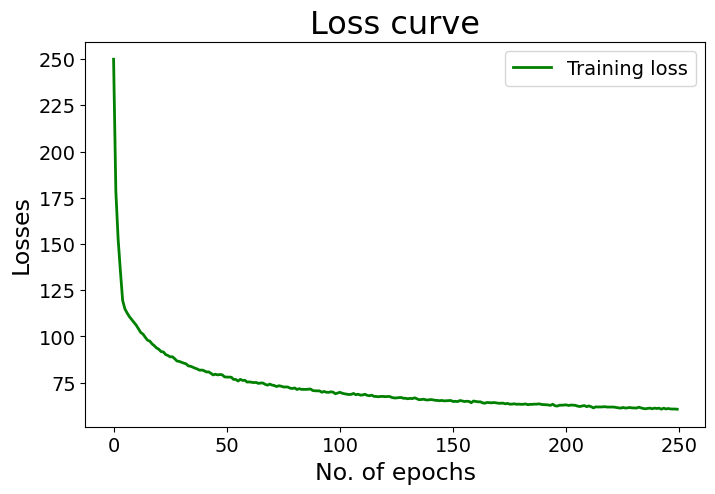

In [12]:
plt.figure(figsize=(8, 5))

plt.plot(training_loss, 'g-', linewidth=2, label='Training loss')
# plt.plot(test_loss, 'c--', linewidth=2, label='Test loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=17)
plt.ylabel('Losses', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14);

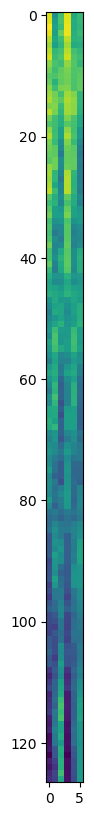

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
data = np.concatenate([traj[0].reshape(-1,3).T,conv_vae(torch.tensor(traj[0]).to(device).reshape(-1,1,127,3))[0].to('cpu').detach().numpy().reshape(-1,3).T])
ax.imshow(data.T)
# ax[0].imshow(traj[0].reshape(-1,3))
# ax[1].imshow(conv_vae(torch.tensor(traj[0]).to(device).reshape(-1,1,127,3))[0].to('cpu').detach().numpy().reshape(-1,3))

In [14]:
traj[0][-1]

array([-0.72329926, -0.60518116,  0.18986614], dtype=float32)

In [15]:
conv_vae(torch.tensor(traj[0]).to(device).reshape(-1,1,127,3))[0].to('cpu').detach().numpy().reshape(-1,3)[-1]

array([-0.76017624, -0.65278137,  0.09903026], dtype=float32)